In [318]:
import pandas as pd
import seaborn as sns
import matplotlib as plt
import numpy as np

sales_url = r"C:\Users\fomin\Analytics\Kaggle_datasets\Zara\zara_sales.csv"
sales = pd.read_csv(sales_url, sep = ';')

sales.head(3)

,Product ID,Product Position,Promotion,Product Category,Seasonal,Sales Volume,brand,url,sku,name,description,price,currency,scraped_at,terms,section
0,185102,Aisle,No,Clothing,No,2823,Zara,https://www.zara.com/us/en/basic-puffer-jacket...,272145190-250-2,BASIC PUFFER JACKET,Puffer jacket made of tear-resistant ripstop f...,19.99,USD,2024-02-19T08:50:05.654618,jackets,MAN
1,188771,Aisle,No,Clothing,No,654,Zara,https://www.zara.com/us/en/tuxedo-jacket-p0889...,324052738-800-46,TUXEDO JACKET,Straight fit blazer. Pointed lapel collar and ...,169.00,USD,2024-02-19T08:50:06.590930,jackets,MAN
2,180176,End-cap,Yes,Clothing,Yes,2220,Zara,https://www.zara.com/us/en/slim-fit-suit-jacke...,335342680-800-44,SLIM FIT SUIT JACKET,Slim fit jacket. Notched lapel collar. Long sl...,129.00,USD,2024-02-19T08:50:07.301419,jackets,MAN


In [319]:
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )

In [320]:
sales.columns = sales.columns.str.lower().str.replace(' ', '_')

# Привожу к удобному для работы виду названия колонок 

In [321]:
sales.shape

(252, 16)

In [322]:
sales['revenue_by_item'] = sales.sales_volume * sales.price

# Ввожу новый столбец, который описывает выручку с айтема - перемножив количество проданного товара на его цену

In [323]:
sales.duplicated().sum()

# Проверка на дубликаты

0

In [324]:
sales.isnull().sum()

# Проверка на нулевые значения

product_id          0
product_position    0
promotion           0
product_category    0
seasonal            0
sales_volume        0
brand               0
url                 0
sku                 0
name                1
description         2
price               0
currency            0
scraped_at          0
terms               0
section             0
revenue_by_item     0
dtype: int64

In [325]:
is_null_df = sales.isnull()
row_with_null = is_null_df.any(axis=1)
rows_with_null = sales[row_with_null]
rows_with_null

# поиск строк, где есть хотя бы одно нулевое значение
# можно дропнуть эти строки из датафрейма, учтя выручку с товаров в них

,product_id,product_position,promotion,product_category,seasonal,sales_volume,brand,url,sku,name,description,price,currency,scraped_at,terms,section,revenue_by_item
60,151925,End-cap,Yes,Clothing,Yes,2179,Zara,https://www.zara.com/us/en/vintage-effect-leat...,320774184-800-97,VINTAGE EFFECT LEATHER BOMBER JACKET,NaN,299.0,USD,2024-02-19T08:50:43.543555,jackets,MAN,651521.0
72,173576,End-cap,Yes,Clothing,No,1838,Zara,https://www.zara.com/us/en/-p04310461.html,336378923-700-2,NaN,NaN,129.0,USD,2024-02-19T08:50:54.476057,jackets,MAN,237102.0


In [326]:
np.round(100 - (sales.revenue_by_item.sum() - rows_with_null.revenue_by_item.sum())/sales.revenue_by_item.sum()*100, 2)

# Считаем % выручки, который уйдет при дропе строчек с нулями

2.28

In [327]:
sales = sales.dropna()

# Дропаем нулевые значения

In [328]:
sales[['product_id', 'revenue_by_item']].sort_values('revenue_by_item').head()

# Способо№1: Считаем выручку по id продукта в списке продаж

,product_id,revenue_by_item
162,136738,4330.58
203,171776,21888.15
189,185307,21916.57
234,185774,22888.55
210,142257,23482.00


In [329]:
sales.groupby('product_id', as_index=False).revenue_by_item.sum().sort_values('revenue_by_item').head()

# Способо№2: Считаем выручку по id продукта в списке продаж, надо разобраться какой способ корректнее
# - вспомнить, что такое product_id на kaggle

,product_id,revenue_by_item
84,136738,4330.58
174,171776,21888.15
212,185307,21916.57
213,185774,22888.55
101,142257,23482.00


In [345]:
sales.name.nunique() - sales.groupby('name').filter(lambda x: len(x) == 1).shape[0]

# Получается 40 уникальных name повторяются в sales

40

In [332]:
nunique_name = sales.groupby('name', as_index=False).agg({'revenue_by_item':'count'}).sort_values('revenue_by_item') \
    .rename(columns={'revenue_by_item':'counts_in_df'})

nunique_name.loc[nunique_name.counts_in_df > 1].head()

# Датафрейм уникальных значений name, которые повторяются 2 или более раз 

,name,counts_in_df
162,SUIT JACKET,2
185,WOOL BLEND JACKET,2
160,SUEDE SNEAKERS,2
167,TECHNICAL PADDED JACKET,2
0,100% FEATHER FILL PUFFER JACKET,2


In [347]:
sales[sales.groupby('name')['name'].transform('size') > 1].sort_values('name').shape

# Все повторящиеся по name строки. Пока просто так сделал, мб потом придумаю что с этим можно еще сделать

(97, 17)

In [334]:
sales \
    .groupby('name', as_index=False) \
    .agg({'revenue_by_item':'sum'}) \
    .sort_values('revenue_by_item')

# Считаем выручку по name продукта в списке продаж

,name,revenue_by_item
78,HIGH COLLAR KNIT SWEATER,4330.58
51,DENIM SHIRT,21888.15
15,BASIC 100% WOOL SWEATER,21916.57
21,BASIC SLIM FIT T-SHIRT,23482.00
134,RETRO SNEAKERS,24885.09
...,...,...
136,RIB COLLAR JACKET,685883.00
118,PLAID OVERSHIRT,695369.00
57,FAUX LEATHER BOMBER JACKET,798852.60
163,SUIT JACKET IN 100% LINEN,816675.00


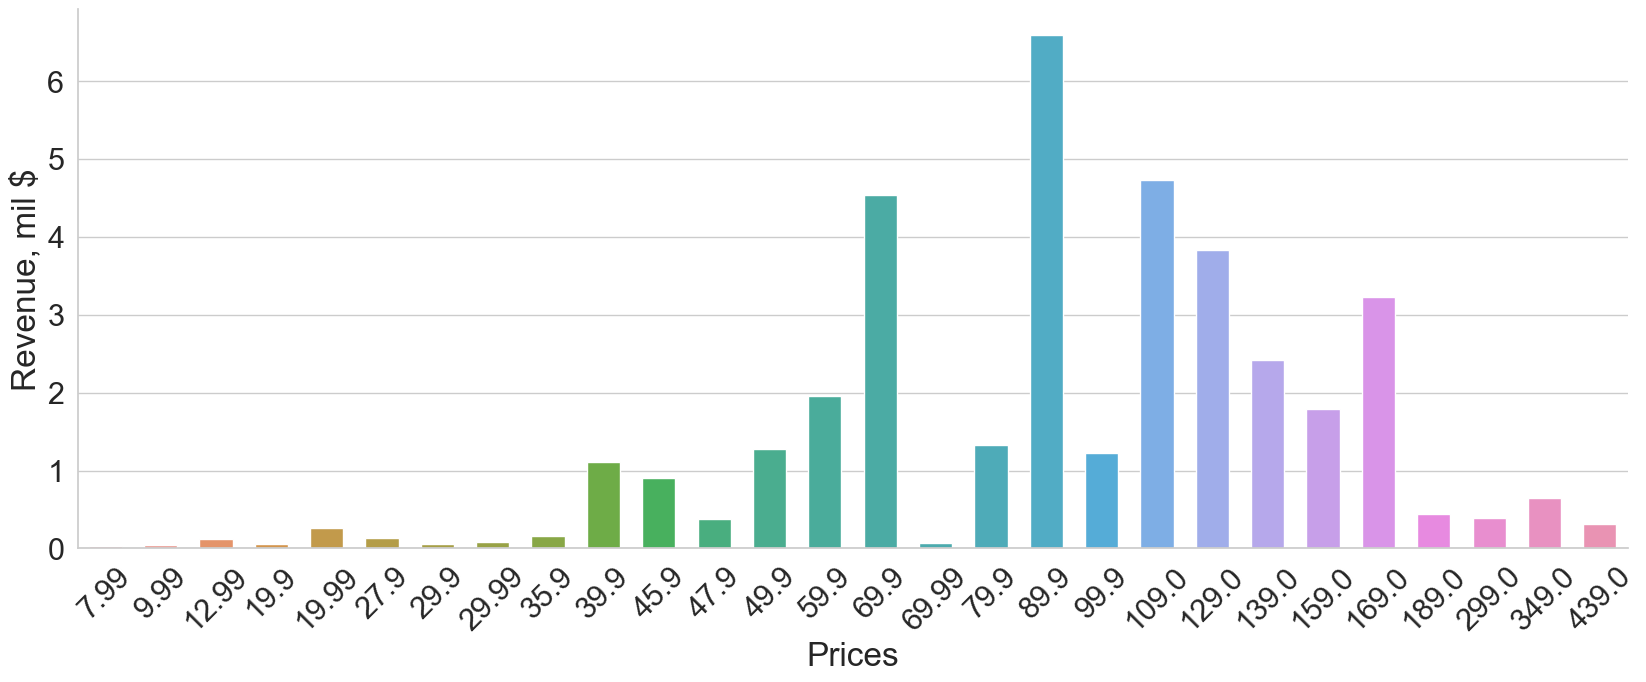

In [335]:
rev_by_price_df = sales \
    .groupby('price', as_index = False) \
    .revenue_by_item.sum()

# Создаем датафрейм выручки, полученной в зависимости от цены айтема

plt.pyplot.xticks(rotation=45)
ax0 = sns.barplot(x = rev_by_price_df.price, y = rev_by_price_df.revenue_by_item/1000000, width = 0.6)
ax0.set(ylabel='Revenue, mil $', xlabel='Prices')
sns.despine()

# Получаем распределение выручки в зависимости от цены вещи - смотрим, какие ценовые сегменты приносят более всего денег


# кластеризуй эти данные по ценам, когда изучишь кластеризацию

<Axes: xlabel='section', ylabel='count'>

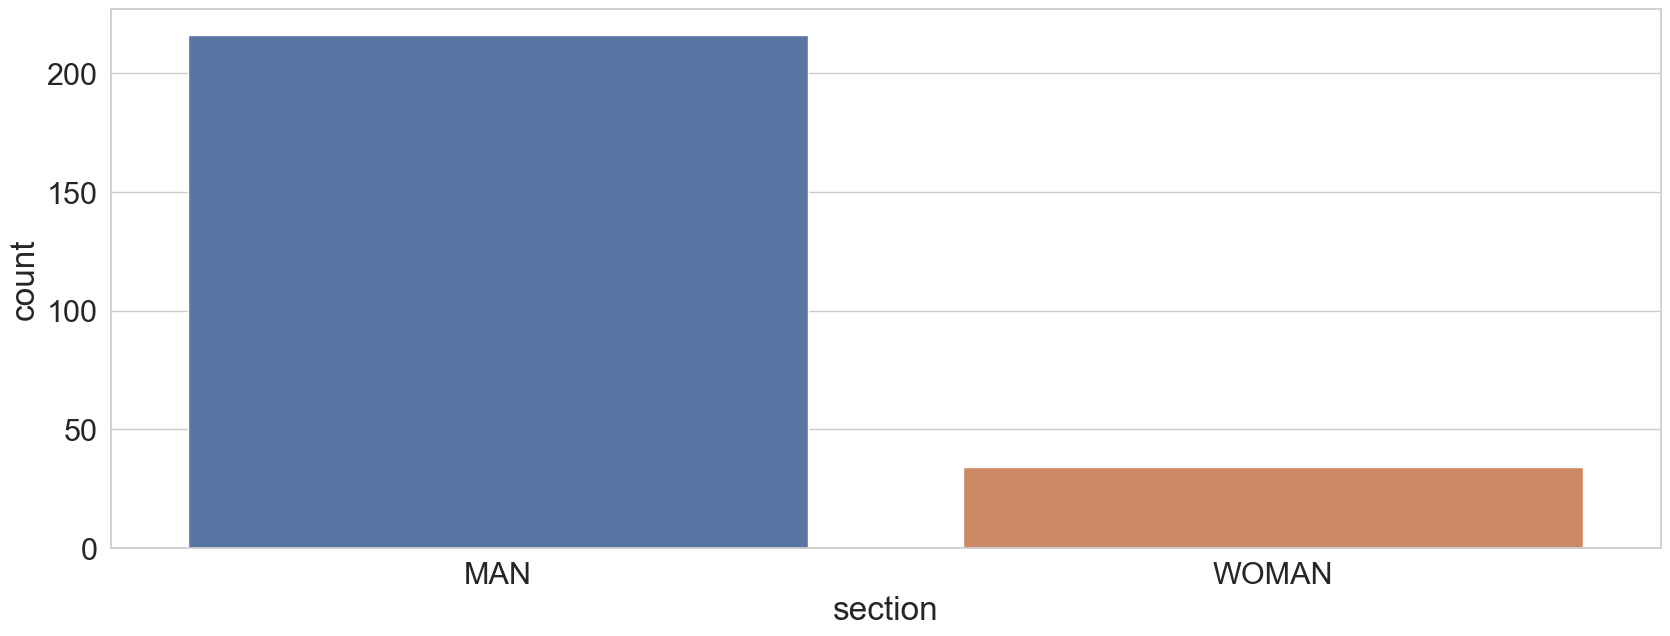

In [336]:
sns.countplot(sales, x = "section")

# Количество покупок в мужском и женском отделах

[Text(0.5, 0, 'Gender'), Text(0, 0.5, 'Revenue, mil $')]

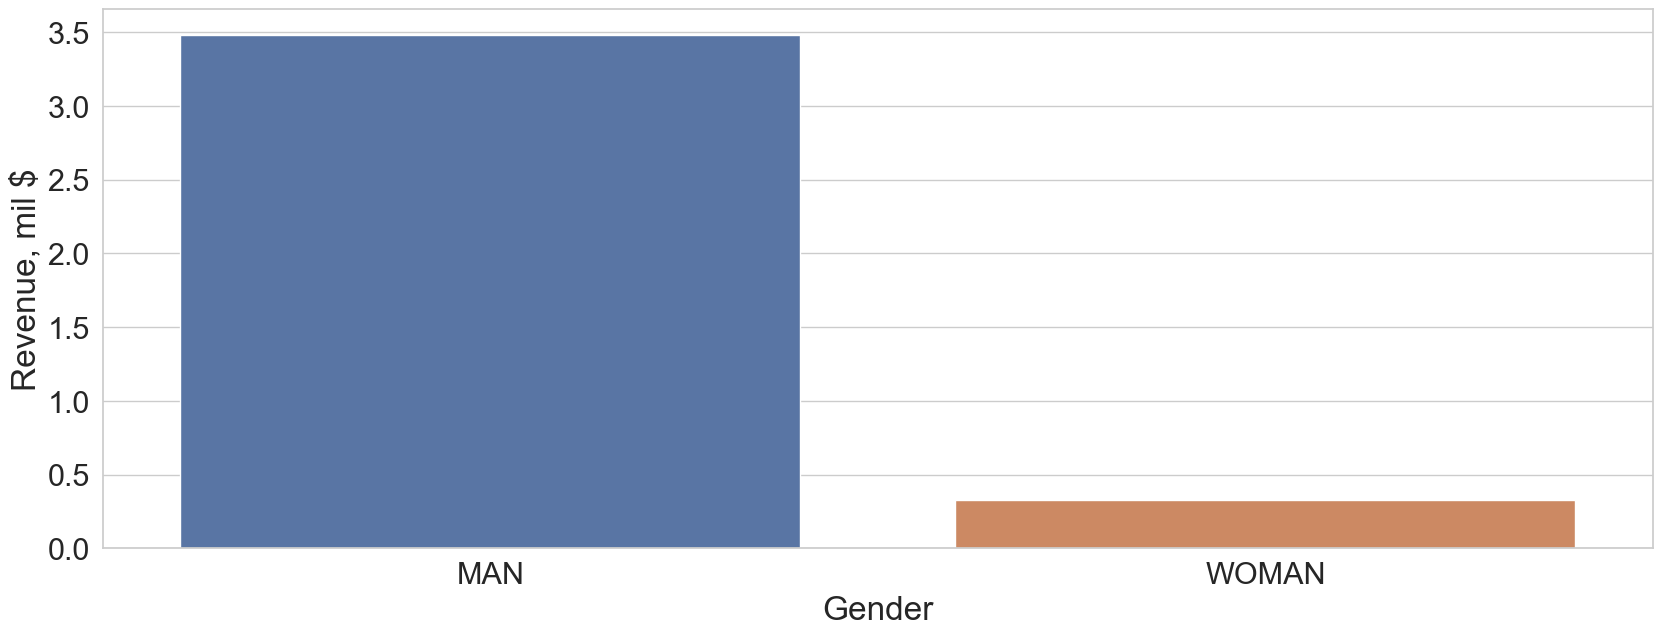

In [370]:
rev_by_gender_df = sales \
    .groupby('section', as_index=False) \
    .revenue_by_item.sum() \
    .rename(columns={'revenue_by_item':'revenue'})

rev_by_gender_df['revenue_share'] = np.round(rev_by_gender_df.revenue / rev_by_gender_df.revenue.sum() * 100,1)

# Создаем датафрейм с выручкой по гендерам rev_by_gender_df
# и отдельно столбец с долей выручки каждого отдела продаж (М и Ж) revenue_share

ax1 = sns.barplot(x=rev_by_gender_df.section, y=rev_by_gender_df.revenue /10000000)
ax1.set(xlabel='Gender', ylabel='Revenue, mil $')
# Выручка, принесенная мужским и женским отделами

In [379]:
count_purch_by_gender_df = sales \
    .groupby('section', as_index=False) \
    .sales_volume.sum() \
    .rename(columns={'sales_volume':'number_of_purchases'})

count_purch_by_gender_df['num_of_purch_share'] = np.round(count_purch_by_gender_df.number_of_purchases / count_purch_by_gender_df.number_of_purchases.sum() * 100,1)
# Создаем датафрейм с количеством покупок по гендерной секции count_purch_by_gender_df
# и отдельно столбец с долей количества покупок каждого отдела продаж (М и Ж) num_of_purch_share

gender_df = rev_by_gender_df.merge(count_purch_by_gender_df)
gender_df['mean_revenue_by_gend'] = np.round(gender_df.revenue / gender_df.number_of_purchases, 2)
gender_df['mean_rev_by_gen_share'] = np.round(gender_df.mean_revenue_by_gend / gender_df.mean_revenue_by_gend.sum() * 100, 2)

gender_df

# Создаем столбец mean_revenue_by_gend, в котором посчитали среднюю выручку с одной покупки для секций мужчин и женщин
# Также создали столбец mean_rev_by_gen_share, в котором посчитали долю секций в средней выручке





# Все относительные показатели, такие, как доля выручки на гендерный отдел, revenue_share,
# доля количества покупок на гендерный отдел, num_of_purch_share,
# и доля в среднем чеке по гендерному отделу, mean_rev_by_gen_share,
# говорят о том, что основной целевой аудиторией магазина являются мужчины, 
# потому что их средняя покупка приносит намного больше денег, в среднем они намного чаще покупают, и их просто больше 

,section,revenue,revenue_share,number_of_purchases,num_of_purch_share,mean_revenue_by_gend,mean_rev_by_gen_share
0,MAN,34824040.03,91.4,392182,86.1,88.80,63.21
1,WOMAN,3275813.45,8.6,63374,13.9,51.69,36.79


<Axes: xlabel='terms', ylabel='Count'>

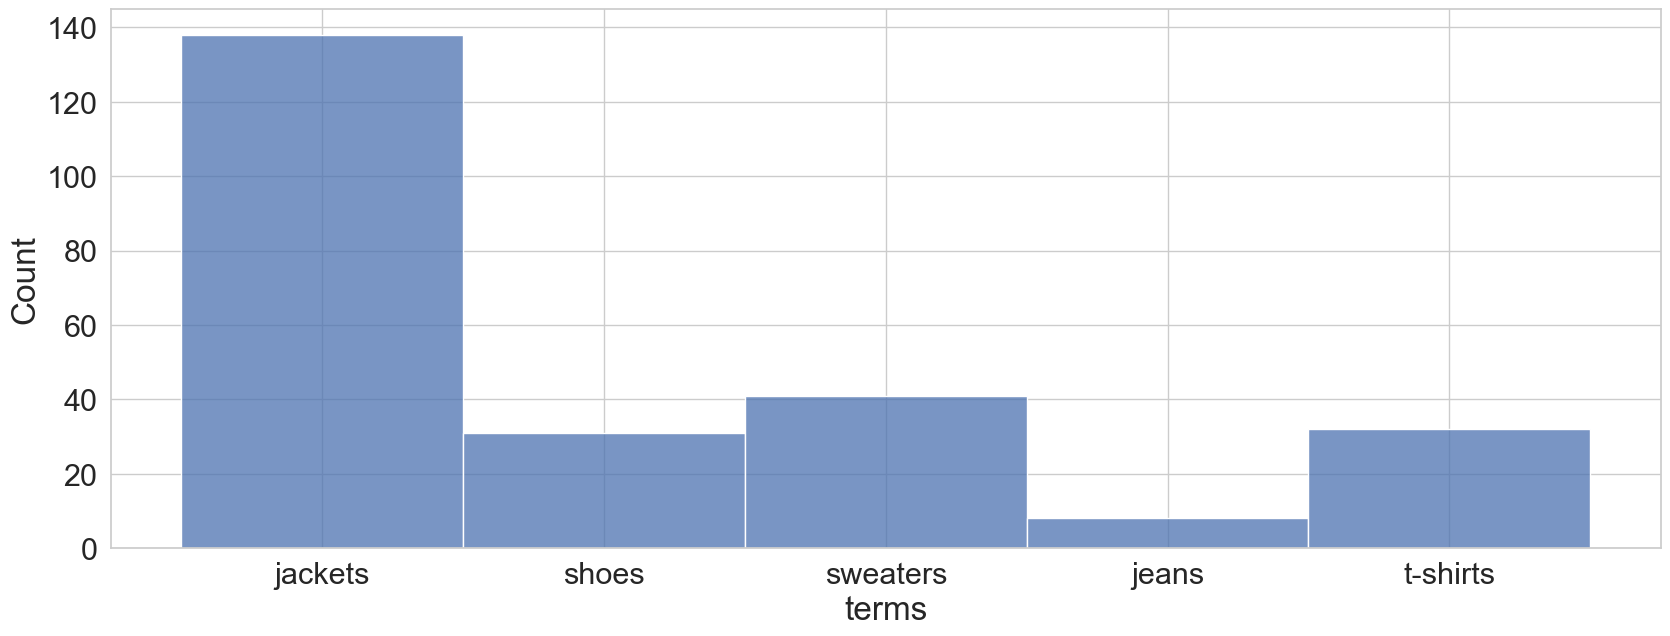

In [339]:
sns.histplot(sales.terms)

# распределение количества товаров по terms

[Text(0, 0.5, 'Revenue, mil $')]

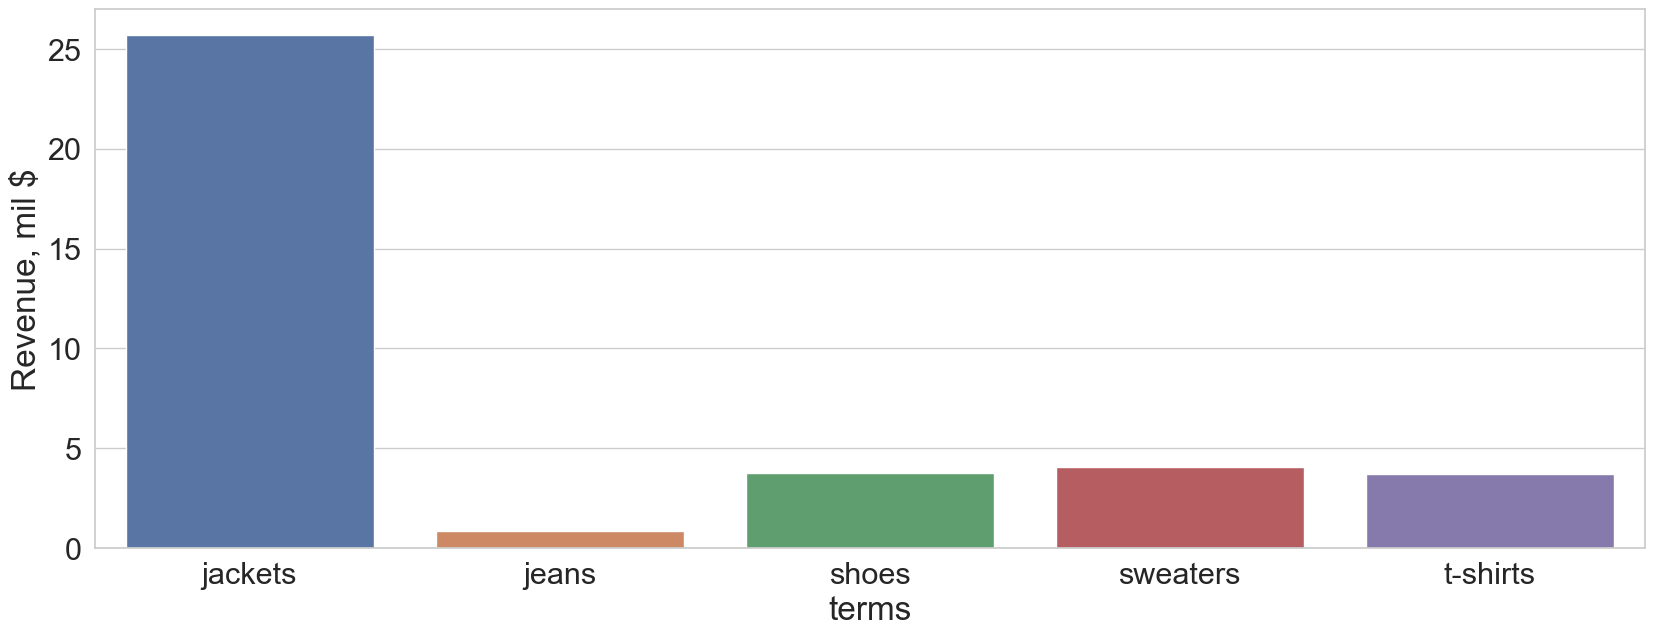

In [340]:
ax2 = sns.barplot(x = sales \
                      .groupby('terms', as_index=False) \
                      .revenue_by_item.sum() \
                      .terms,
                  y = sales \
                      .groupby('terms', as_index=False) \
                      .revenue_by_item.sum() \
                      .revenue_by_item / 1000000)

ax2.set(ylabel = 'Revenue, mil $')

# Распределение выручки по terms